In [1]:
using ComplexSystems, LightGraphs, DelimitedFiles, Plots

In [2]:
function degree_dist(p,k_max)
    pk = zeros(k_max)
    for k in 0:(k_max-1)
        pk[k+1] = (1-exp(-p))*exp(-p*k)
    end
    pk
end

degree_dist (generic function with 1 method)

In [3]:
function CDMX_configuration(x;k_max,prop_deg,R0=2.83,Dinf=2.9,Dincub=5.2,Drl=11.1,Dhosp=5,Drh=15,Duci=2,Druci=10,Dm=4,pgrav=0.15,puci=0.05,pm=0.035)
    y = zeros(length(x))
    
    susceptibles = x[1:k_max]
    infecciosos = x[k_max+1:2*k_max]
    expuestos = x[2*k_max+1:3*k_max]
    leve = x[3*k_max+1:4*k_max]
    grave = x[4*k_max+1:5*k_max]
    hospitalizados = x[5*k_max+1:6*k_max]
    uci = x[6*k_max+1:7*k_max]
    recupuperados = x[7*k_max+1:8*k_max]
    muertos = x[8*k_max+1:end]

    avg_k = collect(1:k_max) .* prop_deg |> sum
    further = collect(1:k_max) .* prop_deg .* expuestos |> sum
    θ = further/avg_k
    for k in 1:k_max
        
        d_sus = -(R0/Dinf)*infecciosos[k]*susceptibles[k]
        d_exp =  (R0/Dinf)*infecciosos[k]*susceptibles[k]-(1/Dincub)*expuestos[k]
        d_inf =  (1/Dincub)*expuestos[k]-(1/Dinf)*infecciosos[k]
        d_leve = (1-pgrav)*(1/Dinf)*infecciosos[k]-(1/Drl)*leve[k]
        d_grav =  pgrav*(1/Dinf)*infecciosos[k]-(1/Dhosp)*grave[k]
        d_hosp = (1/Dhosp)*grave[k]-(1-puci)*(1/Drh)*hospitalizados[k]-puci*(1/Duci)*hospitalizados[k]
        d_uci =   puci*(1/Duci)*hospitalizados[k]-(1-pm)*(1/Druci)*uci[k]-pm*(1/Dm)*uci[k]
        d_rec =  (1/Drl)*leve[k]+(1-puci)*(1/Drh)*hospitalizados[k]+(1-pm)*(1/Druci)*uci[k]
        d_mue =   pm*(1/Dm)*uci[k]
        
        y[k] = d_sus
        y[k_max+k] = d_inf
        y[2*k_max+k] = d_exp
        y[3*k_max+k] = d_leve
        y[4*k_max+k] = d_grav
        y[5*k_max+k] = d_hosp
        y[6*k_max+k] = d_uci
        y[7*k_max+k] = d_rec
        y[8*k_max+k] = d_mue
    end
    y
end

CDMX_configuration (generic function with 1 method)

In [4]:
function make_proportions(compart_num,init_infect)
    susceptible = 1 .- init_infect
    initial = vcat(susceptible, init_infect)
    if compart_num > 2
        for compart in 1:compart_num-2
            initial = vcat(initial, zeros(length(init_infect)))
        end
    end
    initial
end

make_proportions (generic function with 1 method)

In [5]:
kmax = 200
infec = rand(kmax)
all = sum(infec)
prop_inf = infec/all
k_max=kmax;

In [6]:
prop_inf .* collect(1:kmax) |> sum

98.2717727116043

In [7]:
the_proportions = make_proportions(9,prop_inf);

In [8]:
pd = degree_dist(0.4,kmax)
sum(pd)

0.9999999999999999

In [9]:
pd .* collect(1:kmax) |> sum

3.033244781719736

In [10]:
t1,y1 = my_integrator(0,100,1,the_proportions;fun=CDMX_configuration,algo=heun,k_max=kmax,prop_deg=pd,R0=2.83,Dinf=2.9,Dincub=5.2,Drl=11.1,Dhosp=5,Drh=15,Duci=2,Druci=14,Dm=4,pgrav=0.15,puci=0.05,pm=0.035)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9  …  91, 92, 93, 94, 95, 96, 97, 98, 99, 100], [0.99281 0.998382 … 0.0 0.0; 0.987061 0.997077 … 0.0 0.0; … ; 0.0720127 0.0725723 … 0.00419968 0.00415497; 0.0720097 0.0725626 … 0.00421443 0.0041722])

In [11]:
susceptibles = sum(y1[:,1:kmax] .* pd',dims=2)
infecciosos = sum(y1[:,kmax+1:2*kmax] .* pd',dims=2)
expuestos = sum(y1[:,2*kmax+1:3*kmax] .* pd',dims=2)
leve = sum(y1[:,3*kmax+1:4*kmax] .* pd',dims=2)
grave = sum(y1[:,4*kmax+1:5*kmax] .* pd',dims=2)
hospitalizados = sum(y1[:,5*kmax+1:6*kmax] .* pd',dims=2)
uci = sum(y1[:,6*kmax+1:7*kmax] .* pd',dims=2)
recupuperados = sum(y1[:,7*kmax+1:8*kmax] .* pd',dims=2)
muertos = sum(y1[:,8*kmax+1:9*kmax] .* pd',dims=2);

In [12]:
poblacion = 22000000

22000000

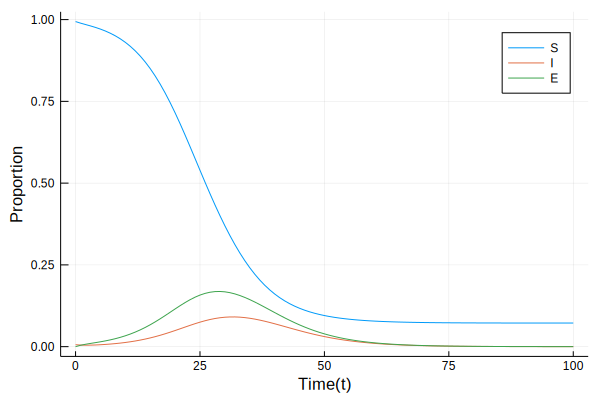

In [13]:
p1=Plots.plot(t1,susceptibles,label="S",xaxis="Time(t)",yaxis="Proportion")
Plots.plot!(t1,infecciosos,label="I")
Plots.plot!(t1,expuestos,label="E")

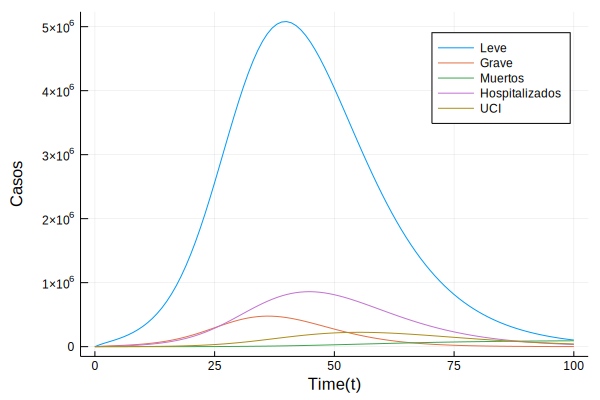

In [14]:
p1=Plots.plot(t1,leve*poblacion,label="Leve",xaxis="Time(t)",yaxis="Casos")
Plots.plot!(t1,grave*poblacion,label="Grave")
Plots.plot!(t1,muertos*poblacion,label="Muertos")
Plots.plot!(t1,hospitalizados*poblacion,label="Hospitalizados")
Plots.plot!(t1,uci*poblacion,label="UCI")

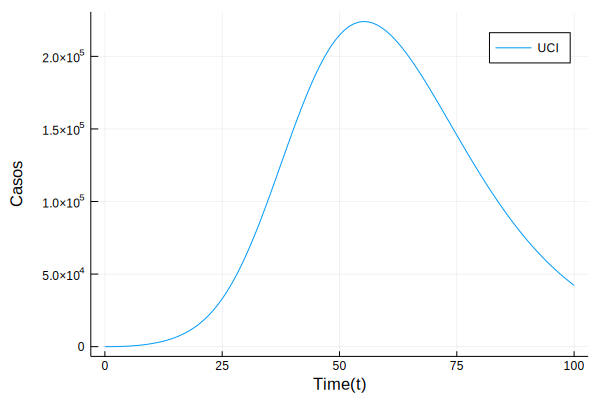

In [15]:
Plots.plot(t1,uci*poblacion,label="UCI",xaxis="Time(t)",yaxis="Casos")

In [16]:
maximum(uci*poblacion)

223971.4482598645